In [12]:
import numpy as np
import pandas as pd
import datetime

import pytest

from Outcomes import outcomes
from SEIR.utils import config

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import glob, os, sys
from pathlib import Path

#import seaborn as sns
import pyarrow.parquet as pq
import click
import pyarrow as pa

import os

import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import glob, os, sys
from pathlib import Path
#import seaborn as sns
import matplotlib._color_data as mcd
import pyarrow.parquet as pq
import click

import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.backends.backend_pdf import PdfPages

from SEIR import NPI, setup, file_paths
from SEIR.utils import config
import pathlib

config_names = ['config_smh_R5_highVac_modNPI_npiredux.yml', 'config_smh_R5_highVac_lowNPI_npiredux.yml']
#config_names = ['config_test_npi_reduce.yml']
ndraw = 10
res = {}

for cn in config_names:
    config.clear()
    config.read(user=False)   


    config.set_file(cn)
    #config.set_file('config_ca_forecast_med_cases_mtr.yml')

    #snpi_fn = 'model_output/snpi/California/Cases/2020.08.18.08:43:53.UTC/000000001.2020.08.18.08:43:53.UTC.snpi.parquet'
    #npi_r =  pq.read_table(snpi_fn).to_pandas()

    scenario = 'inference'
    deathrate = 'med'
    spatial_config = config["spatial_setup"]
    stoch_traj_flag = True
    index = 0
    run_id = 0
    prefix = 0
    spatial_base_path = pathlib.Path(spatial_config["base_path"].get())
    scenario = scenario
    deathrate = deathrate
    stoch_traj_flag= stoch_traj_flag # Truthy: stochastic simulation, Falsy: determnistic mean of the binomial draws
    nsim = 10
    interactive = False
    write_csv = False
    write_parquet = True


    s = setup.Setup(
        setup_name=config["name"].get() + "_" + str(scenario),
        spatial_setup=setup.SpatialSetup(
            setup_name=spatial_config["setup_name"].get(),
            geodata_file=spatial_base_path / spatial_config["geodata"].get(),
            mobility_file=spatial_base_path / spatial_config["mobility"].get(),
            popnodes_key=spatial_config["popnodes"].get(),
            nodenames_key=spatial_config["nodenames"].get()
        ),
        nsim=nsim,
        npi_scenario=scenario,
        npi_config=config["interventions"]["settings"][scenario],
        seeding_config=config["seeding"],
        parameters_config=config["seir"]["parameters"],
        ti=config["start_date"].as_date(),
        tf=config["end_date"].as_date(),
        interactive=interactive,
        write_csv=write_csv,
        write_parquet=write_parquet,
        dt=config["dt"].as_number(),
        first_sim_index = index,
        in_run_id = run_id,
        in_prefix = prefix,
        out_run_id = run_id,
        out_prefix = prefix
    )

    print(f"""
    >> Running ***{'STOCHASTIC' if stoch_traj_flag else 'DETERMINISTIC'}*** SEIR and Outcomes modules;
    >> Setup {s.setup_name}; ti: {s.ti}; tf: {s.tf}; Scenario SEIR: {scenario}; Scenario Outcomes: {deathrate};
    >> index: {s.first_sim_index}; run_id: {run_id}, prefix: {prefix};""")
    
    res[cn]= []
    for i in range(ndraw):
        print(i, end='')
        npi = NPI.NPIBase.execute(npi_config=s.npi_config, global_config=config, geoids=s.spatset.nodenames)
        p_draw = setup.parameters_quick_draw(s.params, len(s.t_inter), s.nnodes)
        parameters = setup.parameters_reduce(p_draw, npi, s.dt)
        res[cn].append(parameters[1][::int(1/s.dt),:])



    >> Running ***STOCHASTIC*** SEIR and Outcomes modules;
    >> Setup USA_inference; ti: 2020-01-01; tf: 2021-10-30; Scenario SEIR: inference; Scenario Outcomes: med;
    >> index: 0; run_id: 0, prefix: 0;
0123456789
    >> Running ***STOCHASTIC*** SEIR and Outcomes modules;
    >> Setup USA_inference; ti: 2020-01-01; tf: 2021-10-30; Scenario SEIR: inference; Scenario Outcomes: med;
    >> index: 0; run_id: 0, prefix: 0;
0123456789

(0.0, 1.5546283607538909)

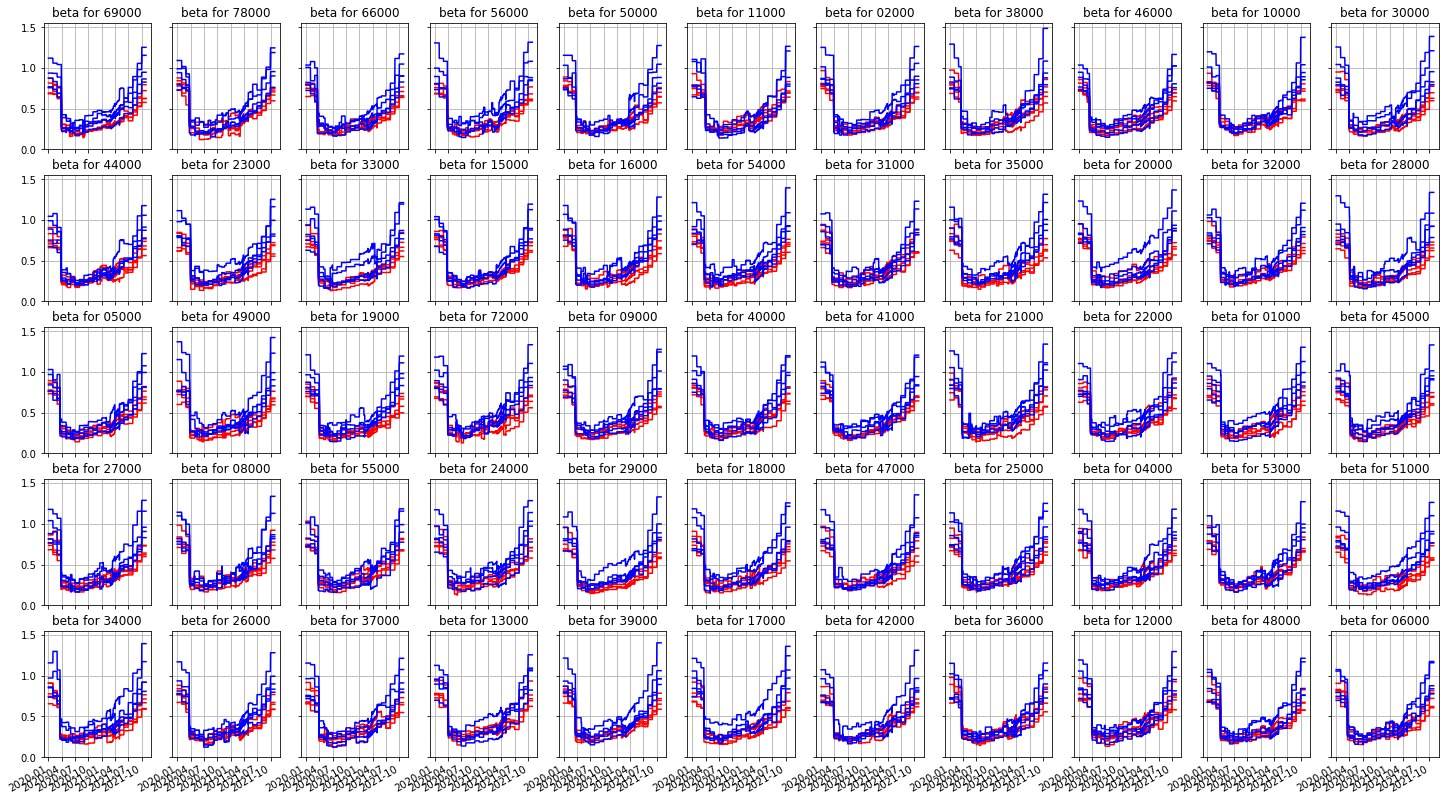

In [2]:
fig, axes = plt.subplots(5,11, figsize=(25,15), sharex = True, sharey = True)
fig.set_facecolor('white')
#fig.suptitle(config_name)

color = ['r','b']

for i, pl in enumerate(s.spatset.nodenames):
    ax = axes.flat[i]
    for k, cn in enumerate(config_names):
        for j in range(ndraw):
            ax.plot(pd.date_range(s.ti, s.tf), res[cn][j][:,i],c = color[k])
    ax.set_title(f'beta for {pl}')
    ax.grid()
#npi.getReduction('r0').T.mean(axis=1).plot(legend=False, ax = ax, lw = 4);

fig.autofmt_xdate()
ax.set_ylim(0)
#ax.set_xlim('2021-04-02', '2021-07-02')

(0.0, 1.3243843066506005)

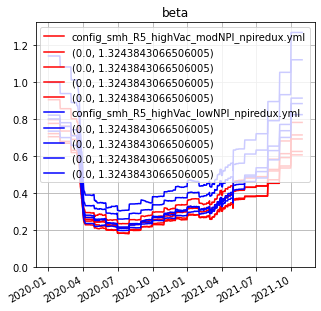

In [11]:
fig, axes = plt.subplots(1,1, figsize=(5,5), sharex = True, sharey = True)
fig.set_facecolor('white')
#fig.suptitle(config_name)

color = ['r','b']


ax = axes
for k, cn in enumerate(config_names):
    for j in range(ndraw):
        if j == 0: 
            label = cn
        else: 
            label = _
        ax.plot(pd.date_range(s.ti, s.tf), res[cn][j][:,:].mean(axis=1),c = color[k], label=label)
ax.set_title(f'beta')
ax.grid()
ax.legend()
#npi.getReduction('r0').T.mean(axis=1).plot(legend=False, ax = ax, lw = 4);

fig.autofmt_xdate()
ax.set_ylim(0)
#ax.set_xlim('2021-04-02', '2021-07-02')

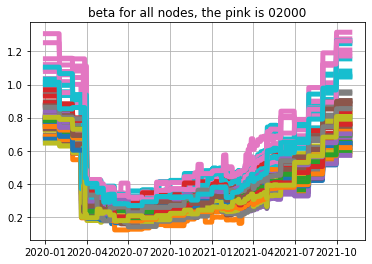

In [3]:
for i, pl in enumerate(s.spatset.nodenames[:7]):
    ax = axes.flat[i]
    for k, cn in enumerate(config_names):
        for j in range(ndraw):
            plt.plot(pd.date_range(s.ti, s.tf), res[cn][j][:,i],lw=5)#,c = color[k])
plt.title(f'beta for all nodes, the pink is 02000')
plt.grid()

In [24]:
res[cn][j][:,7]

array([0.74128697, 0.74128697, 0.74128697, 0.74128697, 0.74128697,
       0.74128697, 0.74128697, 0.74128697, 0.74128697, 0.74128697,
       0.74128697, 0.74128697, 0.74128697, 0.74128697, 0.74128697,
       0.74128697, 0.74128697, 0.74128697, 0.74128697, 0.74128697,
       0.74128697, 0.74128697, 0.74128697, 0.74128697, 0.74128697,
       0.74128697, 0.74128697, 0.74128697, 0.74128697, 0.74128697,
       0.74128697, 0.74128697, 0.74128697, 0.74128697, 0.74128697,
       0.74128697, 0.74128697, 0.74128697, 0.74128697, 0.74128697,
       0.74128697, 0.74128697, 0.74128697, 0.74128697, 0.74128697,
       0.74128697, 0.74128697, 0.74128697, 0.74128697, 0.74128697,
       0.74128697, 0.74128697, 0.74128697, 0.74128697, 0.74128697,
       0.74128697, 0.74128697, 0.74128697, 0.74128697, 0.74128697,
       0.74128697, 0.74128697, 0.74128697, 0.74128697, 0.74128697,
       0.74128697, 0.74128697, 0.74128697, 0.74128697, 0.74128697,
       0.74128697, 0.74128697, 0.74128697, 0.74128697, 0.74128

In [12]:
red[red['npi_name'] == 'NPI' ]

,geoid,npi_name,start_date,end_date,parameter,reduction


In [15]:
red['npi_name'].unique()

array(['local_variance', 'Seas_jan', 'Seas_feb', 'Seas_mar', 'Seas_may',
       'Seas_jun', 'Seas_jul', 'Seas_aug', 'Seas_sep', 'Seas_oct',
       'Seas_nov', 'Seas_dec', 'Dose1_AK_jan2021', 'Dose1_AK_feb2021',
       'Dose1_AK_mar2021', 'Dose1_AK_apr2021', 'Dose1_AK_may2021',
       'Dose1_AK_jun2021', 'Dose1_AK_jul2021', 'Dose1_AK_aug2021',
       'Dose1_AK_sep2021', 'Dose1_AK_oct2021', 'Dose1_AL_jan2021',
       'Dose1_AL_feb2021', 'Dose1_AL_mar2021', 'Dose1_AL_apr2021',
       'Dose1_AL_may2021', 'Dose1_AL_jun2021', 'Dose1_AL_jul2021',
       'Dose1_AL_aug2021', 'Dose1_AL_sep2021', 'Dose1_AL_oct2021',
       'Dose1_AR_jan2021', 'Dose1_AR_feb2021', 'Dose1_AR_mar2021',
       'Dose1_AR_apr2021', 'Dose1_AR_may2021', 'Dose1_AR_jun2021',
       'Dose1_AR_jul2021', 'Dose1_AR_aug2021', 'Dose1_AR_sep2021',
       'Dose1_AR_oct2021', 'Dose1_AZ_jan2021', 'Dose1_AZ_feb2021',
       'Dose1_AZ_mar2021', 'Dose1_AZ_apr2021', 'Dose1_AZ_may2021',
       'Dose1_AZ_jun2021', 'Dose1_AZ_jul2021', 'Dose

In [ ]:
npi.getReductionToWrite()

In [ ]:
(npi.getReductionToWrite() == npi_r).all()

```
                if not isinstance(reduction, float):
                    reduction[reduction>0] = 1
                self.reductions[param] += reduction

            # FIXME: getReductionToWrite() returns a concat'd set of stacked scenario params, which is
            # serialized as a giant dataframe to parquet. move this writing to be incremental, but need to
            # verify there are no downstream consumers of the dataframe. in the meantime, limit the amount
            # of data we'll pin in memory
            if not self.reduction_cap_exceeded:
                if len(self.reduction_params) < REDUCTION_METADATA_CAP:
                    self.reduction_params.append(sub_npi.getReductionToWrite())
                else:
                    self.reduction_cap_exceeded = True
                    self.reduction_params.clear()

        for param in REDUCE_PARAMS:
            self.reductions[param] = self.reductions[param]
```

In [ ]:
ax = npi.getReduction('r0').T.plot(legend=False);
npi.getReduction('r0').T.mean(axis=1).plot(legend=False, ax = ax, lw = 4);
ax.set_facecolor('white')

In [ ]:
plt.plot(beta);
plt.plot(np.mean(beta, axis=1), lw = 4);

In [ ]:
plt.plot(beta);
plt.plot(np.mean(beta, axis=1), lw = 4);

In [ ]:
loaded_df = snpi

In [ ]:
loaded_df.index = loaded_df.geoid
loaded_df = loaded_df[loaded_df['npi_name'] == 'local_variance']
parameters = loaded_df[['npi_name','start_date','end_date','parameter','reduction']]#.copy()
parameters

In [ ]:
loaded_df

In [ ]:
parameters["start_date"] = [[datetime.date.fromisoformat(date) for date in strdate.split(",")] for strdate in parameters["start_date"]]
parameters

In [ ]:
        print(self.parameters["start_date"])        self.parameters["end_date"] = [datetime.date.fromisoformat(date) for date in self.parameters["end_date"]]
        self.affected_geoids = set(self.parameters.index)
        self.param_name = self.parameters["parameter"].unique()

In [ ]:
[datetime.date(2000,1,1),datetime.date(2000,2,1), datetime.date(2000,1,1),datetime.date(2000,2,1)].astype("str")

In [ ]:
b = set([1,2,4])

In [ ]:
import time
s.ti.time.date()